# Sentinova

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126


Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.


## Import Function

In [2]:
import torch
import os

import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tqdm import tqdm  # import tqdm untuk progress bar
nltk.download("punkt")


c:\Users\Adit\Documents\My Life\Project\html\Sentinova\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nltk.download('punkt_tab')

nltk.download("stopwords")
stop_words = set(stopwords.words("indonesian"))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Adit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

No GPU available. Training will run on CPU.


## Read Dataset

In [5]:
#@title Load dataset
df = pd.read_csv('latest_dataset.csv', sep =';',dtype={'Sentiment_Numeric':'Int32'})


# Jika perlu, ubah nama kolom agar seragam
# df.rename(columns={"Review": "Customer Review", "Label": "Sentiment"}, inplace=True)

df.head()


# print(f'\033[94mNumber of records (rows) in the dataset are: {df.shape[0]}')
# print(f'\033[94mNumber of features (columns) in the dataset are: {df.shape[1]}')
# print(f'\033[94mNumber of duplicate entries in the dataset are: {df.duplicated().sum()}')
# print(f'\033[94mNumber missing values in the dataset are: {sum(df.isna().sum())}')

# # df.dropna(subset=['Label'], inplace=True)
# # df.drop_duplicates(subset=['Review'], keep='first', inplace=True)
# # df.drop(['Location', 'Price', 'Number Sold'], axis=1, inplace=True)
# # df.describe().style.background_gradient(cmap='tab20c')
# print(f'\033[94mNumber missing values in the dataset are: {sum(df.isna().sum())}')
df

,Review,Sentiment
0,tidak panas waktu pemakaian compact ringkas di...,1
1,barang diterima dengan baik adminnya juga di t...,1
2,barang tiba dengan baik packing sangat aman ka...,1
3,produk sesuai packing rapih minus di kurir ins...,1
4,in syaa allah aman,1
...,...,...
1841,lemah tidak kuat berdiriapalagi utk posisi men...,0
1842,sesuai harganya build quality nya kurang bagus...,0
1843,kualitasnya mengecewakanblm dipake sudah rusak...,0
1844,sering goyang katanya sih bahan nya dari alumi...,0


## Cleaning Text

In [6]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words('indonesian'))
important_words = {
        'tidak', 'kurang', 'sangat', 'lebih', 'paling', 'banget', 'cukup',
        'hampir', 'lumayan', 'malah', 'hanya', 'cuma', 'tapi', 'namun',
        'meskipun', 'walaupun', 'padahal', 'bahkan', 'sekali', 'aja', 'kok', 'loh', 'dong', 'baik'
    }
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s!?]', '', text)  # Mempertahankan ! dan ?
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words or word in important_words])
    return text
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenisasi
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }
X_train, X_test, y_train, y_test = train_test_split(df["Review"].tolist(), df["Sentiment"].tolist(), test_size=0.2, random_state=42) # 80% untuk training, 20% untuk testing Coba ubah 0.2 menjadi 0.1 atau 0.3 untuk melihat hasilnya
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=3)
# Gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model.to(device)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Model Training

In [7]:
# Hyperparameters
epochs = 10 # coba ubah 50 menjadi 100 atau 200 untuk melihat hasilnya sebagai perbandingan
learning_rate = 2e-5
# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.logits, 1)
        batch_correct = (predicted == labels).sum().item()
        batch_size = labels.size(0)
        total_correct += batch_correct
        total_samples += batch_size
        batch_accuracy = batch_correct / batch_size * 100

        # Backpropagation
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item(), acc=f"{batch_accuracy:.2f}%")

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples * 100
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Training Selesai!")

save_directory = "model"
os.makedirs(save_directory, exist_ok=True)

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model dan Tokenizer berhasil disimpan di {save_directory}")

Epoch 1/10, Loss: 0.2940, Accuracy: 89.97%


Epoch 2/10, Loss: 0.0825, Accuracy: 97.70%


Epoch 3/10, Loss: 0.0416, Accuracy: 98.78%


Epoch 4/10, Loss: 0.0204, Accuracy: 99.53%


Epoch 5/10, Loss: 0.0249, Accuracy: 99.39%


Epoch 6/10, Loss: 0.0093, Accuracy: 99.86%


Epoch 7/10, Loss: 0.0160, Accuracy: 99.66%


Epoch 8/10, Loss: 0.0055, Accuracy: 99.80%


Epoch 9/10, Loss: 0.0040, Accuracy: 99.93%


Epoch 10/10, Loss: 0.0085, Accuracy: 99.86%
Training Selesai!
Model dan Tokenizer berhasil disimpan di model


## Evaluasi Model

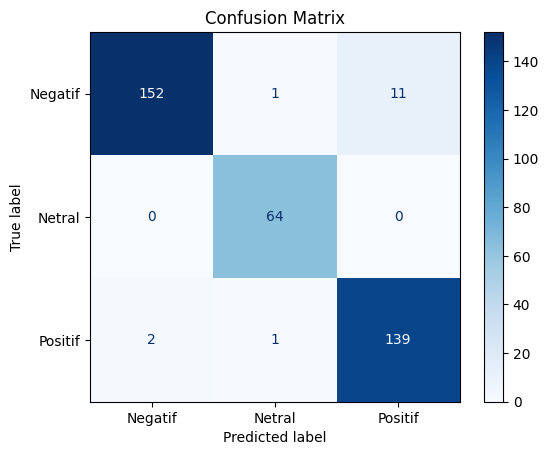

Classification Report:
               precision    recall  f1-score   support

     Negatif       0.99      0.93      0.96       164
      Netral       0.97      1.00      0.98        64
     Positif       0.93      0.98      0.95       142

    accuracy                           0.96       370
   macro avg       0.96      0.97      0.96       370
weighted avg       0.96      0.96      0.96       370



In [8]:
from sklearn.metrics import classification_report

model.eval()
predictions, true_labels = [], []

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tokenize the test data
inputs = tokenizer(X_test, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
    y_pred = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negatif", "Netral", "Positif"])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Menampilkan classification report
report = classification_report(true_labels, predictions, digits=2, target_names=["Negatif", "Netral", "Positif"])
print("Classification Report:\n", report)


## Testing Model

In [9]:
import torch.nn.functional as F

def predict_sentiment(text):
    model.eval()

    # Tokenisasi
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)

    # Gunakan softmax untuk mendapatkan probabilitas
    probabilities = F.softmax(outputs.logits, dim=-1)
    confidence, pred_label = torch.max(probabilities, dim=-1)  # Confidence score & label

    sentiment_map = {0: "Negatif", 1:"Netral" ,2: "Positif"}
    return sentiment_map[pred_label.item()], confidence.item()

# Review sebagai data uji
test_reviews = {
    "Positif": "Produk ini sangat memuaskan! Kualitasnya bagus, sesuai deskripsi, dan performanya luar biasa. Saya pasti merekomendasikannya!",
    "Netral": "coba seminggu semuanya normal, semoga awet.",
    "Negatif": "Saya sangat kecewa dengan produk ini. Kualitasnya buruk, tidak sesuai dengan deskripsi, dan cepat rusak. Pelayanan pelanggan juga lambat dan tidak membantu. Tidak akan membeli lagi."
}

# Evaluasi setiap review
for sentiment, review in test_reviews.items():
    label, confidence = predict_sentiment(review)
    print(f"\nReview {sentiment}: {review} \nHasil Analisis Sentimen: {label} ({confidence:.2%} confidence)")



Review Positif: Produk ini sangat memuaskan! Kualitasnya bagus, sesuai deskripsi, dan performanya luar biasa. Saya pasti merekomendasikannya! 
Hasil Analisis Sentimen: Positif (99.95% confidence)

Review Netral: coba seminggu semuanya normal, semoga awet. 
Hasil Analisis Sentimen: Netral (99.92% confidence)

Review Negatif: Saya sangat kecewa dengan produk ini. Kualitasnya buruk, tidak sesuai dengan deskripsi, dan cepat rusak. Pelayanan pelanggan juga lambat dan tidak membantu. Tidak akan membeli lagi. 
Hasil Analisis Sentimen: Negatif (99.96% confidence)


In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

load_directory = "sentinova_model"
model_loaded = AutoModelForSequenceClassification.from_pretrained(load_directory)
tokenizer_loaded = AutoTokenizer.from_pretrained(load_directory)

# Pastikan ke device yang benar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded.to(device)
model_loaded.eval()

print("Model dan Tokenizer berhasil dimuat ulang!")
print("Model berhasil dimuat ulang")

# Contoh prediksi
def predict(text):
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model_loaded(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
    return prediction

# Contoh penggunaan
sample_text = "barang tidak bagus dan terdapat cacat fisik dan tidak cepat sampai"
predicted_label = predict(sample_text)
print(f"Teks: {sample_text}")
print(f"Prediksi Sentimen: {predicted_label}")

# 0 Negatif
# 1 Netral
# 2 Positif


OSError: sentinova_model is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`